# Lab 07 -- More NN

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/eatongl/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Goals for the lab
- Repeat the logistic regression exercise but add tensorflow logging
- Save the model weights
- Add a hidden layer to the net

In [10]:
import tensorflow as tf
import numpy as np
import os

In [11]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [12]:
# The %run command executes a python file as if it was a cell in the notebook. 
%run plot_images.py

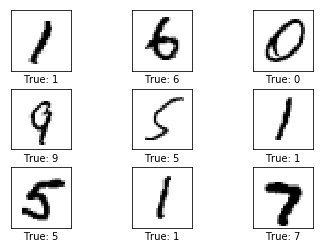

In [13]:
x_batch, y_batch = data.train.next_batch(9)
plot_images(x_batch, y_batch.argmax(1))

# Set up a net to estimate/predict digits

In [14]:
#hyperparameters
num_inputs = 28*28
num_hidden1 = 1024
num_outputs = 10

In [15]:
tf.reset_default_graph()

Input placeholders for the data `x` and the expected (1hot) labels `y`.

In [16]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, (None, 28*28), name='x')
    y = tf.placeholder(tf.float32, (None, 10), name='y')
    ec = tf.argmax(y, 1, name='ec') #[e]xpected [c]lass label
  
    # When this node is run, it will save an image to a log file.
    #  - I am not assigning a variable to the result;,
    #    all of the summary nodes can be collected by inspecting the graph later on. 
    tf.summary.image("image", tf.reshape(x, [-1, 28,28,1]), max_outputs=3);

In [17]:
with tf.name_scope('hidden1'):
    b1 = tf.Variable(tf.zeros(num_hidden1), name='b1')
    W1= tf.Variable(tf.truncated_normal([num_inputs, num_hidden1]), name = 'W1')
    ec = tf.argmax(y, 1, name='ec') #[e]xpected [c]lass label
  
    # When this node is run, it will save an image to a log file.
    #  - I am not assigning a variable to the result;,
    #    all of the summary nodes can be collected by inspecting the graph later on. 
    tf.summary.image("image", tf.reshape(x, [-1, 28,28,1]), max_outputs=3);

In tensorflow, you can create nodes in the graph whose purpose is to save information to log files. The log files can be inspected using a tool called [TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard). I hope to be able to demonstrate it later on in the notebook.

When we save data to the log file, the names become more important. We can group related nodes together using a 'name_scope' in order to make the log files easier to understand. 

In [18]:
with tf.name_scope('output'):
    b = tf.Variable(tf.zeros(num_outputs), name='b')
    W = tf.Variable(tf.truncated_normal([num_inputs, num_outputs]), name='W')
    a = tf.add(tf.matmul(x, W), b, name='a')
    z = tf.nn.softmax(a, name='z')
    pc = tf.argmax(z, 1, name='pc')  # [p]redicted [c]lass label
    
    # Create nodes that will save histograms to the log file
    #  -- histograms are good summaries of the (large) amount of data in the weights. 
    #  -- The let you spot common issues with gradient descent (stalling, diverging)
    tf.summary.histogram("weights", W)
    tf.summary.histogram("biases", b)
    tf.summary.histogram("activations", pc)

The net is now complete for doing _inference_ or _estimation_. That is, you could use it (if the weights were set). Right now the weights are randomly set, the results will be random.

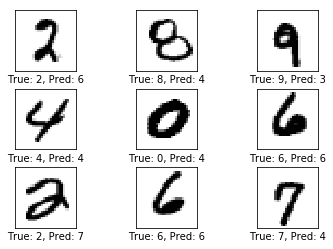

In [19]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

x_batch, y_batch = data.test.next_batch(9)
predictions = sess.run(pc, {x:x_batch, y:y_batch})
plot_images(x_batch, y_batch.argmax(1), predictions)

# Set up the net for evaluation

In [20]:
with tf.name_scope('accuracy'):
    correct = tf.equal(ec, pc, name='correct')  # for each sample, did we get it right? 
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='acc')

    # Create a node to save the accuracy to a log file, 
    # so that we can go back and see how it improves after training. 
    tf.summary.scalar('accuracy', accuracy);

In [21]:
# Normally, we would need to break the test data up into mini-batches.
# however, this set is small enough that we will send the entire 
# test set in as one large batch. 
print "Accuracy:", sess.run(accuracy, {x:data.test.images, y:data.test.labels})
print "Random chance is around 0.10 (10%)"

Accuracy: 0.0837
Random chance is around 0.10 (10%)


# Save the log/summary data

Before we start training, let's look at the log data. 

*NOTE:* All log files will accumulate in the folder unless you delete them, or switch to a different log folder. If you are running this many times and adjusting settings, it is a good idea to think about how to choose differently named log folders for output. 

In [22]:
!mkdir -p ./log/run0

In [23]:
# Collect all of the 'summary' nodes from the graph and generate a single log entry from them. 
summary = tf.summary.merge_all()

In [24]:
# A utility to save summarys to the log directory. 
#  -- This will create a file, each time we add a summary to the writer it gets appended to a log file.
summary_writer = tf.summary.FileWriter('./log/run0', graph=sess.graph)

In [25]:
acc, log =  sess.run([accuracy, summary],
                     {x:data.test.images, y:data.test.labels})
summary_writer.add_summary(log, 0)

In order to train the net, we need to define an objective function to minimize. In this case we will use the cross-entropy loss because our output it a softmax classification. 

In [26]:
from pipes import quote
print "Acuracy:", acc
print 
print "Make sure the correct conda environment is active, then run:"
print "    tensorboard --logdir={} ".format(quote(os.path.abspath('./log')))
print "and open"
print "    http://localhost:6006/"
print "using your web browser"

Acuracy: 0.0837

Make sure the correct conda environment is active, then run:
    tensorboard --logdir=/Users/eatongl/chapter1/labs/lab-07/log 
and open
    http://localhost:6006/
using your web browser


# Set up the graph for training

In [27]:
with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=a)
    loss = tf.reduce_mean(cross_entropy, name='loss')

    # And define a node to log it
    tf.summary.scalar('loss', loss);

In [28]:
with tf.name_scope('solver'):
    solver = tf.train.AdamOptimizer()
    optimize = solver.minimize(loss)

In [29]:
summary_writer = tf.summary.FileWriter('./log/run1/', graph=sess.graph)

In [30]:
# The solver has some parameters that need to be initializes
sess.run(tf.global_variables_initializer())

In [31]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

In [32]:
 # Training cycle
batch_size=100
training_epochs=20
display_epoch=1

try:
    saver.restore(sess, './models/logreg.cpt')
except:
    print "No model to restore"

for epoch in range(training_epochs):
    avg_loss = 0.
    total_batch = int(data.train.num_examples/batch_size)
    
    for i in range(total_batch):
        batch_xs, batch_ys = data.train.next_batch(batch_size)
       
        _, loss_, summary_ = sess.run([optimize, loss, summary],
                                    {x: batch_xs, y: batch_ys})
        
        global_iteration =  epoch * total_batch + i
        summary_writer.add_summary(summary_, global_iteration)
        
        avg_loss += loss_ / total_batch
        
    
    # Display logs per epoch step
    if (epoch+1) % display_epoch == 0:
        print "Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_loss)
    
    saver.save(sess, './models/logreg.cpt')

INFO:tensorflow:Restoring parameters from ./models/logreg.cpt
No model to restore
Epoch: 0001 cost= 4.176605211


ValueError: Parent directory of ./models/logreg.cpt doesn't exist, can't save.

# TODO / Exercise

Let's go back and add a hidden layer